In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Download data
tickers = ['AAPL','MSFT','JPM','V','JNJ','WMT','HD','PG','UNH','INTC',
           'VZ','KO','MRK','BA','CAT','CSCO','CVX','XOM','GS','NKE',
           'TRV','MMM','AXP','MCD','IBM','AMGN','DIS','RTX','DOW','NVDA']
index_ticker = '^DJI'
raw = yf.download(tickers + [index_ticker], start="2015-10-28", end="2025-10-28", progress=False)['Close'].ffill().bfill()

stocks = raw[tickers]
index_price = raw[index_ticker]


/tmp/ipython-input-2899653165.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers + [index_ticker], start="2015-10-28", end="2025-10-28", progress=False)['Close'].ffill().bfill()


Cointegration spread (3y): ADF stat=-7.5714, p=0.0000, n=755
TEV spread (3y): ADF stat=-1.2652, p=0.6449, n=755


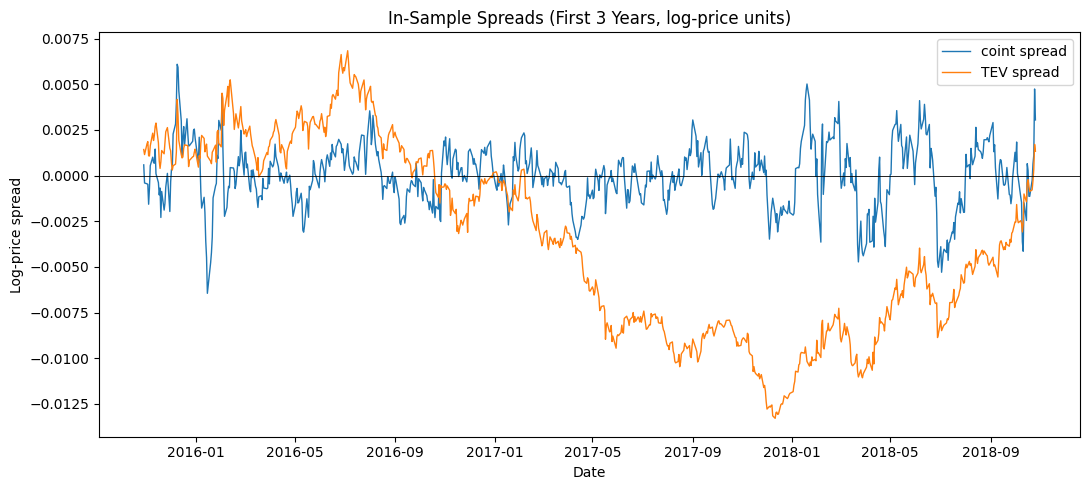

In [3]:
# --- Log prices and log returns ---
log_prices = np.log(stocks)
log_index  = np.log(index_price)
log_returns = log_prices.diff().dropna()
index_logret = log_index.diff().dropna()

# --- Define 3-year window (W = 3) ---
start_date = log_prices.index.min()
end_date = start_date + pd.DateOffset(years=3)

log_prices_w = log_prices.loc[:end_date]
log_index_w = log_index.loc[:end_date]
log_returns_w = log_returns.loc[:end_date]
index_logret_w = index_logret.loc[:end_date]

# --- Cointegration on log prices (within 3 years) ---
Xc = sm.add_constant(log_prices_w)
yc = log_index_w
m_coint = sm.OLS(yc, Xc).fit()
coint_spread = m_coint.resid

# --- TEV regression on log returns (within 3 years) ---
Xl = sm.add_constant(log_returns_w)
yl = index_logret_w
m_tev = sm.OLS(yl, Xl).fit()
pred_logret = pd.Series(m_tev.predict(Xl), index=Xl.index)  # predicted Δln P

# --- Build TEV portfolio log-price by accumulating predicted Δln P ---
ln_start = log_index_w.loc[pred_logret.index[0]]             # first ln-price
ln_portfolio = ln_start + pred_logret.cumsum()               # reconstructed ln P_portfolio

# --- Compute TEV price spread ---
ln_index_cal = log_index_w.reindex(ln_portfolio.index)
tev_spread = (ln_index_cal - ln_portfolio).rename("TEV_price_spread").dropna()

# --- Align cointegration spread to same dates ---
coint_spread_aligned = coint_spread.reindex(tev_spread.index).rename("Coint_price_spread").dropna()

# --- ADF tests ---
def run_adf(series, name):
    stat, p, *_ = adfuller(series, maxlag=12, regression='c')
    print(f"{name}: ADF stat={stat:.4f}, p={p:.4f}, n={len(series)}")

run_adf(coint_spread_aligned, "Cointegration spread (3y)")
run_adf(tev_spread, "TEV spread (3y)")

# --- Plot spreads (3 years) ---
plt.figure(figsize=(11,5))
plt.plot(coint_spread_aligned, label='coint spread', linewidth=1)
plt.plot(tev_spread, label='TEV spread', linewidth=1)
plt.axhline(0, color='k', linewidth=0.6)
plt.title('In-Sample Spreads (First 3 Years, log-price units)')
plt.xlabel('Date'); plt.ylabel('Log-price spread')
plt.legend(); plt.tight_layout(); plt.show()


processed window ending 2018-10-18
processed window ending 2019-10-17
processed window ending 2020-10-14
processed window ending 2021-10-12
processed window ending 2022-10-10
processed window ending 2023-10-09
processed window ending 2024-10-07
processed window ending 2025-10-07


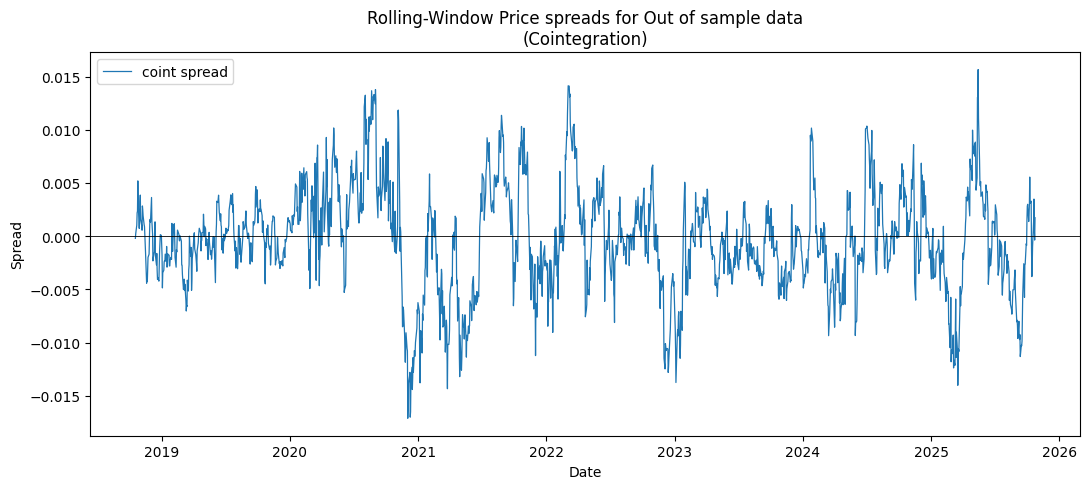

In [4]:
window = 750  # 3 years
dates = log_index.index
n = len(dates)

coint_last = []
spread_dates = []

for start in range(0, n - window):
    end = start + window
    sub_dates = dates[start:end]


    X_c = sm.add_constant(log_prices.loc[sub_dates])
    y_c = log_index.loc[sub_dates]
    model_c = sm.OLS(y_c, X_c).fit()
    eps_c = model_c.resid.iloc[-1]  # last-day price residual

    coint_last.append(eps_c)
    spread_dates.append(sub_dates[-1])


    if start % 250 == 0:
        print(f"processed window ending {sub_dates[-1].date()}")


rolling_spreads = pd.DataFrame({
    "coint_spread": coint_last
}, index=pd.to_datetime(spread_dates))

# --- plot rolling last-day spreads
plt.figure(figsize=(11,5))
plt.plot(rolling_spreads.index, rolling_spreads["coint_spread"], label="coint spread", linewidth=0.9)
plt.axhline(0, color='k', linewidth=0.6)
plt.title("Rolling-Window Price spreads for Out of sample data\n(Cointegration)")
plt.xlabel("Date"); plt.ylabel("Spread")
plt.legend(); plt.tight_layout(); plt.show()


In [5]:
# ---------- Paste and run: corrected Exhibit-2 metrics (final block) ----------
import numpy as np, pandas as pd, statsmodels.api as sm, cvxpy as cp
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis
import yfinance as yf
from tqdm import tqdm

# 1) download / prepare data (if you already have prices/index_price defined you can skip download)
tickers = ['AAPL','MSFT','JPM','V','JNJ','WMT','HD','PG','UNH','INTC',
           'VZ','KO','MRK','BA','CAT','CSCO','CVX','XOM','GS','NKE',
           'TRV','MMM','AXP','MCD','IBM','AMGN','DIS','RTX','DOW','NVDA']
index_ticker = '^DJI'
raw = yf.download(tickers + [index_ticker], start="2015-10-28", end="2025-10-28", progress=False)['Close']
raw = raw.ffill().bfill()

prices = raw[tickers].copy()
index_price = raw[index_ticker].copy()

# 2) transforms
log_prices = np.log(prices)
log_index  = np.log(index_price)
returns = prices.pct_change()           # arithmetic returns for TEV
index_returns = index_price.pct_change()

# align
common = returns.index.intersection(index_returns.index)
returns = returns.reindex(common)
index_returns = index_returns.reindex(common)
prices = prices.reindex(common)
log_prices = log_prices.reindex(common)
log_index = log_index.reindex(common)
dates = common
n = len(dates)

# parameters
cal_days = 750
holding_periods = {'fortnight':10, 'monthly':21, '3_monthly':63, '6_monthly':126}

# helpers
def constrained_ls_with_intercept_np(X_np, y_np):
    T,k = X_np.shape
    w = cp.Variable(k); b0 = cp.Variable()
    obj = cp.Minimize(cp.sum_squares(y_np - (b0 + X_np @ w)))
    cons = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.OSQP, verbose=False)
    wv = np.array(w.value).flatten() if w.value is not None else np.zeros(k)
    return float(b0.value) if b0.value is not None else 0.0, wv

def tev_constrained_minvar_df(R_df):
    Σ = R_df.cov().values
    k = Σ.shape[0]
    w = cp.Variable(k)
    obj = cp.Minimize(cp.quad_form(w, Σ))
    cons = [w >= 0, cp.sum(w) == 1]
    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.OSQP, verbose=False)
    return np.array(w.value).flatten() if w.value is not None else np.zeros(k)

ann_factor = np.sqrt(252)

# storage
results = {}

for name, hold_days in holding_periods.items():
    rebal_ends = list(range(cal_days-1, n-1, hold_days))
    te_c_un = []; te_c_cv = []; te_t_un = []; te_t_cv = []
    adf_c_list = []; adf_t_list = []
    skipped = 0
    for end_idx in tqdm(rebal_ends, desc=name, leave=False):
        start_idx = end_idx - (cal_days - 1)
        cal_dates = dates[start_idx:end_idx+1]
        hold_start = end_idx + 1
        hold_end = min(end_idx + hold_days, n - 1)
        hold_dates = dates[hold_start:hold_end+1]
        if len(hold_dates) == 0:
            continue

        # require no NaNs in calibration and hold windows for chosen tickers
        cal_lp = log_prices.loc[cal_dates, tickers]
        cal_r  = returns.loc[cal_dates, tickers]
        hold_r = returns.loc[hold_dates, tickers]
        cal_idx_r = index_returns.loc[cal_dates]
        hold_idx_r = index_returns.loc[hold_dates]

        ok = cal_lp.columns[cal_lp.notna().all() & cal_r.notna().all() & hold_r.notna().all()]
        if len(ok) == 0:
            skipped += 1
            continue

        cal_lp_ok = cal_lp[ok]
        cal_r_ok  = cal_r[ok]
        hold_r_ok = hold_r[ok]

        # --- Cointegration (log-prices) ---
        mc = sm.OLS(log_index.loc[cal_dates], sm.add_constant(cal_lp_ok)).fit()
        eps_c = mc.resid.dropna()
        # unconstrained cointegration weights: normalize when applying
        params_c = mc.params
        w_c_un = np.array([params_c.get(t,0.0) for t in ok])
        if np.abs(w_c_un.sum()) < 1e-12:
            skipped += 1
            continue
        w_c_un_norm = w_c_un / w_c_un.sum()
        # constrained cointegration (nonneg, sum=1) on price levels
        _, w_c_cv = constrained_ls_with_intercept_np(cal_lp_ok.values, log_index.loc[cal_dates].values)
        # normalize constrained safety
        if w_c_cv.sum() != 0:
            w_c_cv = w_c_cv / w_c_cv.sum()

        # --- TEV (arithmetic returns) ---
        # use cal_r_ok[1:] aligned with index_returns[1:]
        if cal_r_ok.shape[0] <= 1:
            skipped += 1
            continue
        Xr = sm.add_constant(cal_r_ok.iloc[1:])
        yr = index_returns.loc[cal_r_ok.index[1:]]
        mt = sm.OLS(yr, Xr).fit()
        params_t = mt.params
        w_t_un = np.array([params_t.get(t,0.0) for t in ok])   # raw OLS coeffs
        # constrained TEV: min-var on cal_r_ok
        w_t_cv = tev_constrained_minvar_df(cal_r_ok)

        # safety normalize constrained TEV (should already sum to 1)
        if np.abs(w_t_cv.sum())>0:
            w_t_cv = w_t_cv / w_t_cv.sum()

        # --- Out-of-sample realized tracking errors (apply weights to realized hold returns) ---
        pr_c_un = hold_r_ok.dot(w_c_un_norm)
        pr_c_cv = hold_r_ok.dot(w_c_cv)
        pr_t_un = hold_r_ok.dot(w_t_un)
        pr_t_cv = hold_r_ok.dot(w_t_cv)

        te_c_un.append((pr_c_un - hold_idx_r).values)
        te_c_cv.append((pr_c_cv - hold_idx_r).values)
        te_t_un.append((pr_t_un - hold_idx_r).values)
        te_t_cv.append((pr_t_cv - hold_idx_r).values)

        # --- ADF stats ---
        # cointegration ADF on price residuals
        try:
            adf_c_list.append(adfuller(eps_c)[0])
        except Exception:
            adf_c_list.append(np.nan)

        # TEV ADF on price spread built from predicted arithmetic returns (calibration window)
        try:
            pred_ret = mt.predict(sm.add_constant(cal_r_ok.iloc[1:]))         # predicted arithmetic returns on cal
            start_price = index_price.loc[cal_r_ok.index[1]]
            port_price = start_price * (1 + pd.Series(pred_ret, index=cal_r_ok.index[1:])).cumprod()
            ln_idx_cal = np.log(index_price.reindex(port_price.index))
            tev_price_spread = (ln_idx_cal - np.log(port_price)).dropna()
            adf_t_list.append(adfuller(tev_price_spread)[0])
        except Exception:
            adf_t_list.append(np.nan)

    # flatten TE lists
    def flatten(arrays):
        return np.concatenate(arrays) if len(arrays)>0 else np.array([])

    te_c_un_all = flatten(te_c_un)
    te_c_cv_all = flatten(te_c_cv)
    te_t_un_all = flatten(te_t_un)
    te_t_cv_all = flatten(te_t_cv)

    # metrics
    def metrics_from_te(te_series, adf_list):
        if te_series.size == 0:
            return {'avg_annual_TE_pct':np.nan,'TE_annual_vol_pct':np.nan,'skew':np.nan,'xs_kurt':np.nan,'ADF':np.nan}
        avg_ann = np.mean(te_series) * 252 * 100
        vol_ann = np.std(te_series) * ann_factor * 100
        sk = skew(te_series)
        kt = kurtosis(te_series) - 3  # excess kurtosis
        adf_m = np.nanmean(adf_list) if len(adf_list)>0 else np.nan
        return {'avg_annual_TE_pct':avg_ann,'TE_annual_vol_pct':vol_ann,'skew':sk,'xs_kurt':kt,'ADF':adf_m}

    res = {
        'coint_un': metrics_from_te(te_c_un_all, adf_c_list),
        'coint_cv': metrics_from_te(te_c_cv_all, adf_c_list),
        'tev_un':   metrics_from_te(te_t_un_all, adf_t_list),
        'tev_cv':   metrics_from_te(te_t_cv_all, adf_t_list),
        'n_rebalances': len(rebal_ends),
        'skipped_windows': skipped
    }
    results[name] = res
    print(f"{name} done: rebalances={res['n_rebalances']} skipped={res['skipped_windows']}")

# pretty print (paper-like compact)
methods = [
    ('coint_un','Cointegration (Unconstrained)'),
    ('coint_cv','Cointegration (Constrained)'),
    ('tev_un','TEV (Unconstrained)'),
    ('tev_cv','TEV (Constrained)')
]
freq_order = ['fortnight','monthly','3_monthly','6_monthly']

for key, title in methods:
    print(f"\n=== {title} ===")
    print(f"{'Metric':<30}" + "".join([f"{f:<12}" for f in freq_order]))
    print("-"*30 + "-"*12*len(freq_order))
    for metric_label, colname in [('avg_annual_TE_pct','Average annual TE (%)'),
                                  ('TE_annual_vol_pct','Tracking error annual (%)'),
                                  ('skew','Tracking error skew'),
                                  ('xs_kurt','Tracking error xs kurt'),
                                  ('ADF','ADF statistic')]:
        row = f"{colname:<30}"
        for freq in freq_order:
            val = results[freq][key].get(metric_label if metric_label in results[freq][key] else metric_label.replace('xs_kurt','xs_kurt'), np.nan)
            row += f"{(val if not pd.isna(val) else np.nan):<12.4f}"
        print(row)

# save CSV for record
out_rows = []
for freq in freq_order:
    for m_key, m_title in methods:
        r = results[freq][m_key]
        out_rows.append({'frequency':freq,'method':m_title,
                         'Average annual TE (%)':r['avg_annual_TE_pct'],
                         'Tracking error annual (%)':r['TE_annual_vol_pct'],
                         'Tracking error skew':r['skew'],
                         'Tracking error xs kurt':r['xs_kurt'],
                         'ADF statistic':r['ADF']})
pd.DataFrame(out_rows).to_csv("exhibit2_metrics_final.csv", index=False)
print("\nSaved exhibit2_metrics_final.csv")
# ---------- end block ----------


/tmp/ipython-input-3177235242.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers + [index_ticker], start="2015-10-28", end="2025-10-28", progress=False)['Close']


fortnight done: rebalances=177 skipped=1


monthly done: rebalances=84 skipped=1


3_monthly done: rebalances=28 skipped=1


6_monthly done: rebalances=14 skipped=1

=== Cointegration (Unconstrained) ===
Metric                        fortnight   monthly     3_monthly   6_monthly   
------------------------------------------------------------------------------
Average annual TE (%)         3.2353      2.9770      3.6560      3.5981      
Tracking error annual (%)     4.6091      4.5086      4.6273      3.7134      
Tracking error skew           -0.1915     -0.3128     1.9113      0.4166      
Tracking error xs kurt        13.1189     13.4853     26.3444     -0.1163     
ADF statistic                 -7.8700     -7.9019     -7.8476     -7.7323     

=== Cointegration (Constrained) ===
Metric                        fortnight   monthly     3_monthly   6_monthly   
------------------------------------------------------------------------------
Average annual TE (%)         3.4717      3.1219      2.9490      3.4224      
Tracking error annual (%)     3.3703      3.3761      3.5484      3.6179      
Tracking error 